PyTorch Geometric의 `Data` 객체는 그래프 데이터를 표현하는 데 사용되며, 다음과 같은 메소드를 가지고 있습니다:

1. `__init__`: 객체를 초기화하는 메소드입니다. 이 메소드는 `Data` 객체가 생성될 때 자동으로 호출됩니다.

2. `num_nodes`: 그래프의 노드 수를 반환하는 메소드입니다.

3. `num_edges`: 그래프의 엣지 수를 반환하는 메소드입니다.

4. `num_faces`: 그래프의 면 수를 반환하는 메소드입니다.

5. `num_features`: 그래프의 특징 수를 반환하는 메소드입니다.

6. `contains_isolated_nodes`: 그래프가 고립된 노드를 포함하는지 여부를 반환하는 메소드입니다.

7. `contains_self_loops`: 그래프가 자기 루프를 포함하는지 여부를 반환하는 메소드입니다.

8. `is_directed`: 그래프가 방향성을 가지는지 여부를 반환하는 메소드입니다.

9. `is_undirected`: 그래프가 방향성을 가지지 않는지 여부를 반환하는 메소드입니다.

10. `apply`: 그래프의 노드, 엣지, 면, 특징에 함수를 적용하는 메소드입니다.

11. `to`: 데이터를 특정 장치로 이동하는 메소드입니다.

12. `clone`: `Data` 객체의 복제본을 생성하는 메소드입니다.

13. `__cat_dim__`: 특정 키에 대한 연결 차원을 반환하는 메소드입니다.

14. `__inc__`: 특정 키에 대한 증가 차원을 반환하는 메소드입니다.

15. `__getitem__`: 특정 키의 값을 가져오는 메소드입니다.

16. `__setitem__`: 특정 키의 값을 설정하는 메소드입니다.

17. `__len__`: `Data` 객체의 길이를 반환하는 메소드입니다.

18. `__contains__`: `Data` 객체가 특정 키를 포함하는지 여부를 반환하는 메소드입니다.

19. `__iter__`: `Data` 객체의 반복자를 반환하는 메소드입니다.

20. `__call__`: `Data` 객체를 호출하는 메소드입니다.

21. `__repr__`: `Data` 객체의 문자열 표현을 반환하는 메소드입니다.

이러한 메소드들은 그래프 데이터를 다루는 데 필요한 기본적인 연산을 제공합니다. 각 메소드의 사용법은 PyTorch Geometric의 공식 문서나 해당 메소드에 대한 도움말을 참조하시면 됩니다.
$$
m_{i \rightarrow j}(Y_j)=\sum_{Y_i \in \mathcal{L}}\psi (Y_i, Y_j) \phi_i(Y_i) \Pi_{k \in N_i \backslash j}m_{k \rightarrow i}(Y_i)\forall Y_j \in \mathcal{L}
$$

In [1]:
import torch
from torch_geometric.nn import GCNConv
from torch_geometric.datasets import KarateClub
import torch.nn.functional as F

# Load the Karate Club dataset
dataset = KarateClub()
data = dataset[0]  # Get the first graph object

In [2]:
# Define the GNN model
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = GCNConv(dataset.num_features, 16)
        self.conv2 = GCNConv(16, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)  # specify the dropout rate
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)

In [3]:
# Instantiate the model and optimizer
model = Net()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

In [4]:
# Training loop
model.train()
for epoch in range(100000):
    optimizer.zero_grad()
    out = model(data)
    loss = torch.nn.functional.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

Accuracy: 0.6176


IndexError: list index out of range

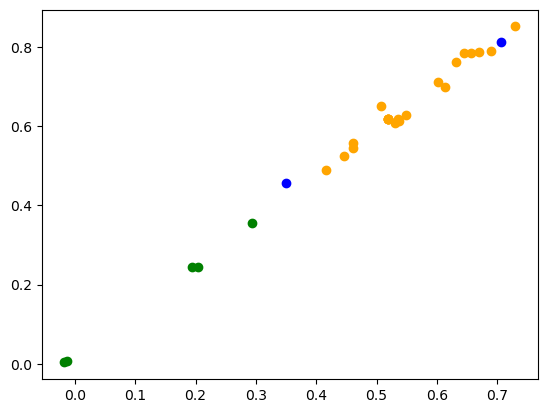

In [7]:
import matplotlib.pyplot as plt
import numpy as np

num_nodes = data.num_nodes  # Get the number of nodes
test_mask = torch.zeros(num_nodes, dtype=torch.bool)  # Create a mask of all zeros
test_mask[-int(num_nodes):] = 1  # Set the last 20% of the mask to 1
data.test_mask = test_mask  # Add the test mask to the data object


# Switch model to evaluation mode
model.eval()

# Make predictions
_, pred = model(data).max(dim=1)

# Calculate accuracy
correct = float(pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
acc = correct / data.test_mask.sum().item()
print('Accuracy: {:.4f}'.format(acc))

# Visualization
colors = ['orange', 'blue', 'green']

# Get the embeddings of the graph
embeddings = model.conv1(data.x, data.edge_index).detach().numpy()

# Create a scatter plot
for i in range(dataset.num_classes):
    class_indices = (pred == i).nonzero().numpy().flatten()
    plt.scatter(embeddings[class_indices, 0], embeddings[class_indices, 1], color=colors[i])

plt.show()
